In [2]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split, KFold
print(tf.__version__)

2.9.1


In [3]:
data_path = "./TCIR-ALL_2017.h5"
data_info = pd.read_hdf(data_path, key="info", mode='r')
with h5py.File(data_path, 'r') as hf:
    data_matrix = hf['matrix'][:]

In [4]:
print("Min Intensity ",data_info.Vmax.min())
print("Max Intensity ",data_info.Vmax.max())
print("Mean Intensity ",round(data_info.Vmax.mean(),2))

Min Intensity  15.0
Max Intensity  155.0
Mean Intensity  48.14


In [5]:
np.shape(data_matrix)

(4580, 201, 201, 4)

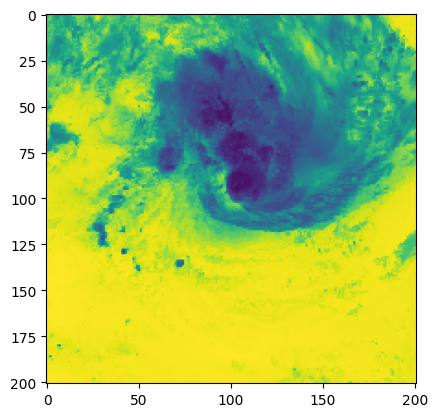

In [6]:
img = data_matrix[4000,:,:,0].copy()
fig, ax = plt.subplots()
pos = ax.imshow(img)

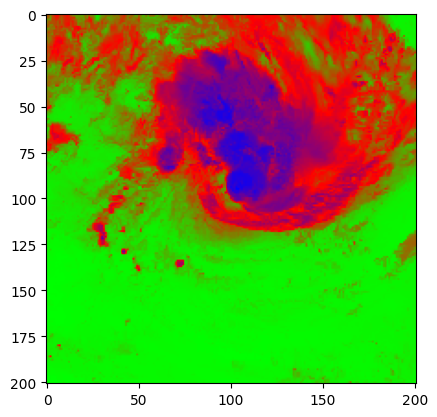

In [7]:
img = data_matrix[4000,:,:,0].copy()
fig, ax = plt.subplots()
pos = ax.imshow(img,plt.cm.brg)

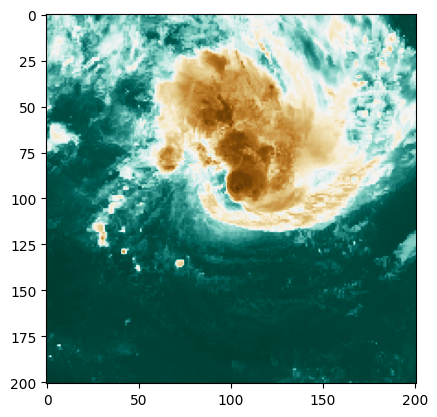

In [8]:
img = data_matrix[4000,:,:,0].copy()
fig, ax = plt.subplots()
pos = ax.imshow(img,plt.cm.BrBG)

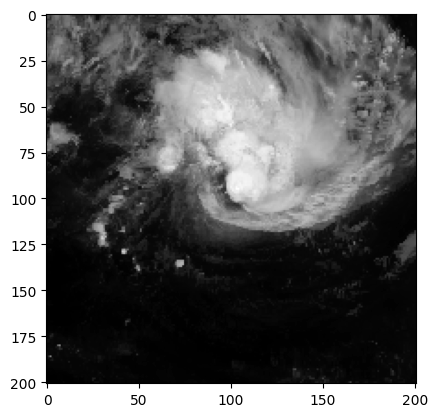

In [9]:
img = data_matrix[4000,:,:,0].copy()
fig, ax = plt.subplots()
pos = ax.imshow(img,plt.cm.binary)

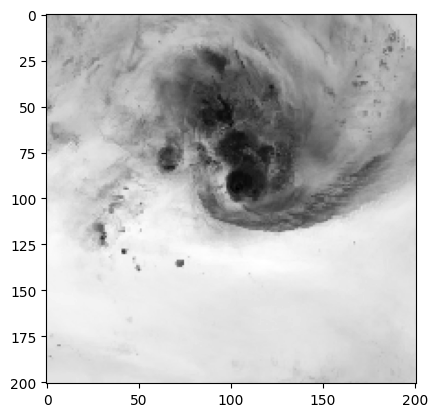

In [10]:
img = data_matrix[4000,:,:,1].copy()
fig, ax = plt.subplots()
pos = ax.imshow(img, plt.cm.gray)

In [11]:
data_info = data_info.assign(time=pd.to_datetime(data_info.time, format=r'%Y%m%d%H'))

In [12]:
data_info

,data_set,ID,lon,lat,time,Vmax,R35_4qAVG,MSLP
0,ATLN,201701L,-50.3,35.8,2017-04-16 06:00:00,55.0,270.0,992.0
1,ATLN,201701L,-49.9,35.5,2017-04-16 09:00:00,55.0,270.0,990.0
2,ATLN,201701L,-49.5,35.1,2017-04-16 12:00:00,55.0,270.0,989.0
3,ATLN,201701L,-49.1,34.8,2017-04-16 15:00:00,55.0,262.5,988.0
4,ATLN,201701L,-48.7,34.4,2017-04-16 18:00:00,55.0,255.0,986.0
...,...,...,...,...,...,...,...,...
4575,WPAC,201733W,105.0,8.4,2017-12-26 00:00:00,20.0,0.0,1007.0
4576,WPAC,201733W,104.7,8.4,2017-12-26 03:00:00,20.0,0.0,1007.0
4577,WPAC,201733W,104.4,8.4,2017-12-26 06:00:00,20.0,0.0,1007.0
4578,WPAC,201733W,104.0,8.4,2017-12-26 09:00:00,18.0,0.0,1009.0


In [13]:
## keep only IR and PMW
X_irpmw = data_matrix[:,:,:,0::3]
y = data_info['Vmax'].values[:,np.newaxis]

In [14]:
X_irpmw[np.isnan(X_irpmw)] = 0
X_irpmw[X_irpmw > 1000] = 0

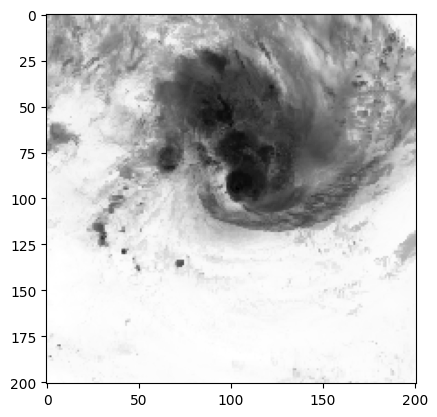

In [15]:
# X_std = tf.image.per_image_standardization(X_irpmw)
img = data_matrix[4000,:,:,0].copy()
fig, ax = plt.subplots()
pos = ax.imshow(img, plt.cm.gray)

In [16]:
class Preprocessing(keras.layers.Layer):
    def __init__(self):
        super(Preprocessing, self).__init__()
    def call(self, inputs, training=None):
        if training:
            inputs = tf.image.rot90(inputs, k=np.random.randint(4))
        return tf.image.central_crop(inputs, 0.5)

## Deep CNN

In [25]:

def train_val_model(train_x,train_y,val_x,val_y, n_epochs, batch_size):
    reg_param = 1e-5
    
    train_X = tf.convert_to_tensor(train_x)
    train_Y = tf.convert_to_tensor(train_y)
    
    val_X = tf.convert_to_tensor(val_x)
    val_Y = tf.convert_to_tensor(val_y)
    
    weights_initializer = keras.initializers.GlorotUniform()
    

    model = keras.models.Sequential([
        Preprocessing(),
        keras.layers.Conv2D(filters=16, kernel_size=4, strides=2, padding='valid', activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='valid', activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding='valid', activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Conv2D(filters=128, kernel_size=3, strides=2, padding='valid', activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Flatten(),
        keras.layers.Dense(256, activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Dense(128, activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Dense(1, activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
    ])
    #Compiling the model
    model.compile(optimizer=keras.optimizers.Adam(lr=5e-4, beta_1=0.99, beta_2=0.9999),
                  loss='mean_squared_error', 
                  metrics=['mean_squared_error'], 
                 )

    #Training the network
    history = model.fit(train_X,train_Y, 
         epochs=n_epochs,
         batch_size=batch_size, 
         verbose=1
        )
    
    val_score = model.evaluate(val_X, val_Y)
    print("Val Score: ",val_score)
    return history,val_score,model


In [26]:
model_history=[]
val_scores=[]
n_epochs=10
batch_size=64
train_x, val_x, train_y, val_y = train_test_split(X_irpmw, y, random_state = 101, test_size=0.1)
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, random_state = 101, test_size=0.1)
history,val_score,model = train_val_model(train_x,train_y,val_x,val_y, n_epochs, batch_size)
model_history.append(history)
val_scores.append(val_score)

C:\Users\ASUS\AppData\Roaming\Python\Python310\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
58/58 [==============================] - 5s 72ms/step - loss: 1134.6034 - mean_squared_error: 1134.5962
Epoch 2/10
58/58 [==============================] - 4s 75ms/step - loss: 800.2098 - mean_squared_error: 800.2029
Epoch 3/10
58/58 [==============================] - 5s 83ms/step - loss: 696.6574 - mean_squared_error: 696.6511
Epoch 4/10
58/58 [==============================] - 5s 85ms/step - loss: 450.7782 - mean_squared_error: 450.7719
Epoch 5/10
58/58 [==============================] - 5s 84ms/step - loss: 376.6105 - mean_squared_error: 376.6043
Epoch 6/10
58/58 [==============================] - 5s 84ms/step - loss: 367.9329 - mean_squared_error: 367.9266
Epoch 7/10
58/58 [==============================] - 5s 86ms/step - loss: 322.6926 - mean_squared_error: 322.6861
Epoch 8/10
58/58 [==============================] - 5s 88ms/step - loss: 291.9114 - mean_squared_error: 291.9049
Epoch 9/10
58/58 [==============================] - 5s 82ms/step - loss: 283.1241 - mean_squar

In [27]:
y_pred = model.predict(test_x)
print('Testing...')
score = model.evaluate(test_x,test_y,
                     batch_size=16, verbose=1)
print('Test accuracy:', score[1])

13/13 [==============================] - 0s 13ms/step
Testing...
26/26 [==============================] - 0s 10ms/step - loss: 358.2548 - mean_squared_error: 358.2483
Test accuracy: 358.2483215332031


In [122]:
intensity = []
for x in y_pred:
    intensity.append(int(x))

In [123]:
# Categorize the cyclone intensity levels
cate = []
for x in intensity:
    if x <= 33:
        cate.append('Low')
    elif x > 33 and x <= 63:
        cate.append('Moderate')
    elif x > 63 and x <= 129:
        cate.append('High')
    elif x > 129:
        cate.append('Very High')

In [124]:
cate_dataset = list(zip(intensity,cate))

In [125]:
df = pd.DataFrame(cate_dataset,columns=['Intensity','Risk type',])

In [126]:
df

,Intensity,Risk type
0,34,Moderate
1,34,Moderate
2,23,Low
3,61,Moderate
4,26,Low
...,...,...
408,34,Moderate
409,31,Low
410,35,Moderate
411,25,Low


RNN

In [106]:
x_train = np.random.rand(100, 10, 4)  # Time series data with shape (samples, timesteps, features)
y_train = np.random.rand(100, 1)      # Target values

# Define the RNN model
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(units=64, activation='relu', input_shape=(10, 4)),  # Adjust units and input shape as needed
    tf.keras.layers.Dense(units=1)  # Output layer with 1 unit for regression
])


In [107]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

# Train the model
model.fit(x_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
4/4 [==============================] - 2s 3ms/step - loss: 0.0950 - mean_squared_error: 0.0950
Epoch 2/10
4/4 [==============================] - 0s 14ms/step - loss: 0.0788 - mean_squared_error: 0.0788
Epoch 3/10
4/4 [==============================] - 0s 4ms/step - loss: 0.0782 - mean_squared_error: 0.0782
Epoch 4/10
4/4 [==============================] - 0s 4ms/step - loss: 0.0767 - mean_squared_error: 0.0767
Epoch 5/10
4/4 [==============================] - 0s 3ms/step - loss: 0.0749 - mean_squared_error: 0.0749
Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.0721 - mean_squared_error: 0.0721
Epoch 7/10
4/4 [==============================] - 0s 4ms/step - loss: 0.0719 - mean_squared_error: 0.0719
Epoch 8/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0690 - mean_squared_error: 0.0690
Epoch 9/10
4/4 [==============================] - 0s 3ms/step - loss: 0.0670 - mean_squared_error: 0.0670
Epoch 10/10
4/4 [============================

In [108]:
# Make predictions using the trained model
rnn_y_pred = model.predict(x_train)

4/4 [==============================] - 0s 2ms/step


In [127]:
import pandas as pd

# Convert predicted intensity values to integers
intensity = []
for x in y_pred:
    intensity.append(int(x))

# Categorize the cyclone intensity levels
cate = []
for x in intensity:
    if x <= 33:
        cate.append('Low')
    elif x > 33 and x <= 63:
        cate.append('Moderate')
    elif x > 63 and x <= 129:
        cate.append('High')
    elif x > 129:
        cate.append('Very High')

# Create a DataFrame
data = {'Intensity value': intensity, 'Risk type': cate}
df = pd.DataFrame(data)

df


,Intensity value,Risk type
0,34,Moderate
1,34,Moderate
2,23,Low
3,61,Moderate
4,26,Low
...,...,...
408,34,Moderate
409,31,Low
410,35,Moderate
411,25,Low


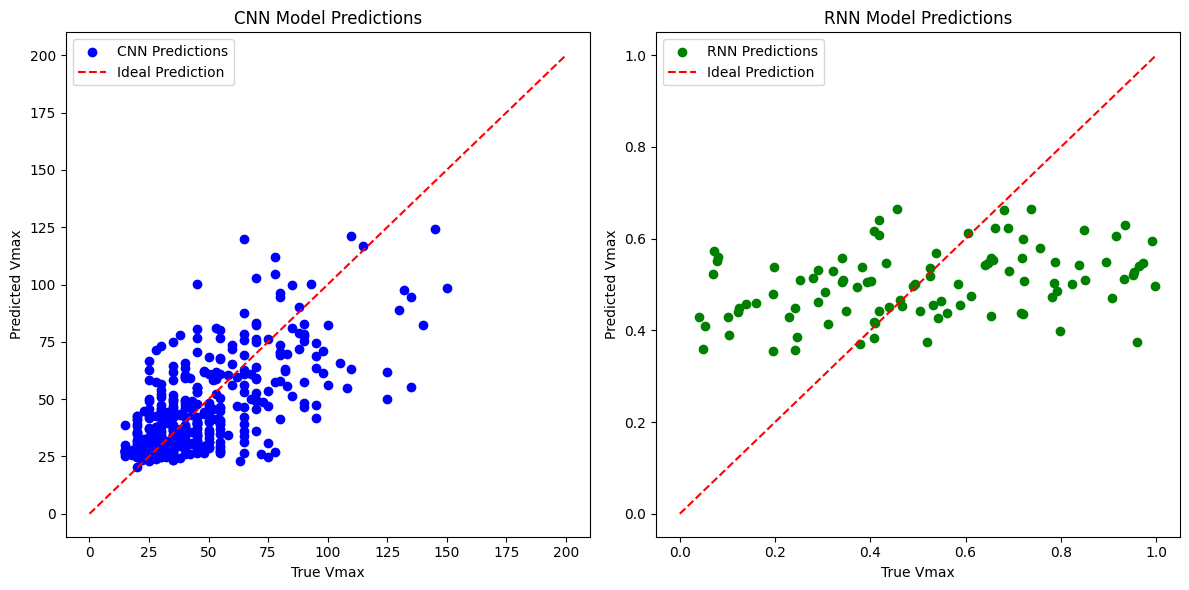

In [119]:
import matplotlib.pyplot as plt

# Create a scatter plot for CNN predictions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(test_y, y_pred, color='blue', label='CNN Predictions')
plt.plot([0, 200], [0, 200], color='red', linestyle='--', label='Ideal Prediction')
plt.xlabel('True Vmax')
plt.ylabel('Predicted Vmax')
plt.title('CNN Model Predictions')
plt.legend()

# Create a scatter plot for RNN predictions
plt.subplot(1, 2, 2)
plt.scatter(y_train, rnn_y_pred, color='green', label='RNN Predictions')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Ideal Prediction')
plt.xlabel('True Vmax')
plt.ylabel('Predicted Vmax')
plt.title('RNN Model Predictions')
plt.legend()

plt.tight_layout()
plt.show()
